# Import All Libs

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from warnings import filterwarnings
from sklearn.linear_model import LinearRegression
filterwarnings('ignore')
%matplotlib inline

In [136]:
api_url = "https://api.covid19india.org/csv/latest/state_wise_daily.csv"

In [137]:
data= pd.read_csv(api_url)

In [138]:
data.head(10)

,Date,Status,TT,AN,AP,AR,AS,BR,CH,CT,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,14-Mar-20,Confirmed,81,0,1,0,0,0,0,0,...,1,3,0,1,1,0,12,0,0,0
1,14-Mar-20,Recovered,9,0,0,0,0,0,0,0,...,0,1,0,0,0,0,4,0,0,0
2,14-Mar-20,Deceased,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15-Mar-20,Confirmed,27,0,0,0,0,0,0,0,...,0,1,0,0,2,0,1,0,0,0
4,15-Mar-20,Recovered,4,0,0,0,0,0,0,0,...,0,2,0,0,1,0,0,0,0,0
5,15-Mar-20,Deceased,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,16-Mar-20,Confirmed,15,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
7,16-Mar-20,Recovered,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,16-Mar-20,Deceased,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,17-Mar-20,Confirmed,11,0,0,0,0,0,0,0,...,0,0,0,0,1,0,2,0,1,0


In [180]:
def getStateData(state, cumsum=False):
    state_data = data[state]
    if cumsum:
        state_data = state_data.cumsum()
        
    state_data = pd.DataFrame(
        state_data.values.reshape(-1, 3),
        columns=['Confirmed', 'Recovered', 'Deceased'],
        index=pd.date_range(
            start='14-Mar-20',
            end=data['Date'].iloc[-1]).strftime("%B%d"))    
    
    
    return state_data

In [184]:
def CreateWindow(state_data, stack):
    confirmed = state_data['Confirmed']
    recovered = state_data['Recovered']
    deceased = state_data['Deceased']
    
    
    scaler_confirmed = StandardScaler()
    scaler_recovered = StandardScaler()
    scaler_deceased = StandardScaler()
    
    confirmed = scaler_confirmed.fit_transform(confirmed.values.reshape(-1,1)).reshape(-1)
    recovered = scaler_recovered.fit_transform(recovered.values.reshape(-1,1)).reshape(-1)
    deceased = scaler_deceased.fit_transform(deceased.values.reshape(-1,1)).reshape(-1)
   
    def _(_data):
        data = []
        for i in range(1,stack):
            temp = np.roll(_data, -i)[:-stack]
            data.append(temp)
        data = np.concatenate([i.reshape(-1,1) for i in data],axis=1)
        return data,np.roll(_data, -stack)[:-stack]
    return _(confirmed), _(recovered),_(deceased), (scaler_confirmed,scaler_recovered,scaler_deceased)

In [201]:
def PlotAndPridict(state, days):
    state_data = getStateData(state)
    #create Window
    Confirmed, Confirmed, Confirmed, scalers = CreateWindow(state_data, 5)

    #  Create Three Model for Each Predication
    ConfirmedModel = LinearRegression()
    RecoveredModel = LinearRegression()
    DeceasedModel = LinearRegression()

    dates = pd.date_range(start=data['Date'].iloc[-1],periods=days).strftime("%B%d")


    confirmed_x, confirmed_y = Confirmed
    recovered_x, recovered_y = Confirmed
    deceased_x, deceased_y = Confirmed

    ConfirmedModel.fit(confirmed_x, confirmed_y)
    RecoveredModel.fit(recovered_x, recovered_y)
    DeceasedModel.fit(deceased_x, deceased_y)


    def PredictNext(data, model, days):
        prediction = []
        data = data[-1]
        for i in range(days):
            temp = model.predict([data])
            prediction.append(temp[0])
            data = np.roll(data, -1)
            data[-1] = temp
        return prediction

    scaler_confirmed,scaler_recovered,scaler_deceased = scalers

    confirmed_predictions = PredictNext(confirmed_x, ConfirmedModel, days)
    recovered_predictions = PredictNext(recovered_x, RecoveredModel, days)
    deceased_predictions = PredictNext(deceased_x, DeceasedModel, days)
    
    confirmed_predictions = scaler_confirmed.inverse_transform(confirmed_predictions)
    recovered_predictions = scaler_recovered.inverse_transform(recovered_predictions)
    deceased_predictions = scaler_deceased.inverse_transform(deceased_predictions)
    fig = plt.figure(figsize=(17,10),dpi=200)
    
    ax = plt.subplot(311)
    ax.set_title('Confirmed Prediction')
    ax.plot(dates,
        confirmed_predictions,
            marker='o', 
            label='Confirmed',
            color='cyan',
           linewidth=3)

    ax = plt.subplot(312)
    ax.set_title('Recovered Prediction')
    ax.plot(dates, recovered_predictions, marker='o', c='green',label='Recovered',linewidth=3)
    ax = plt.subplot(313)
    ax.set_title('Deceased Prediction')
    ax.plot(dates, deceased_predictions, marker='o', c='r',label='Deceased')
    
    plt.xticks(rotation=90)
    
    plt.title(state)
    
    plt.legend()


In [202]:
import ipywidgets as widgets
from IPython.display import display,clear_output

Dropdown(description='State:', options=('TT', 'AN', 'AP', 'AR', 'AS', 'BR', 'CH', 'CT', 'DN', 'DD', 'DL', 'GA'…

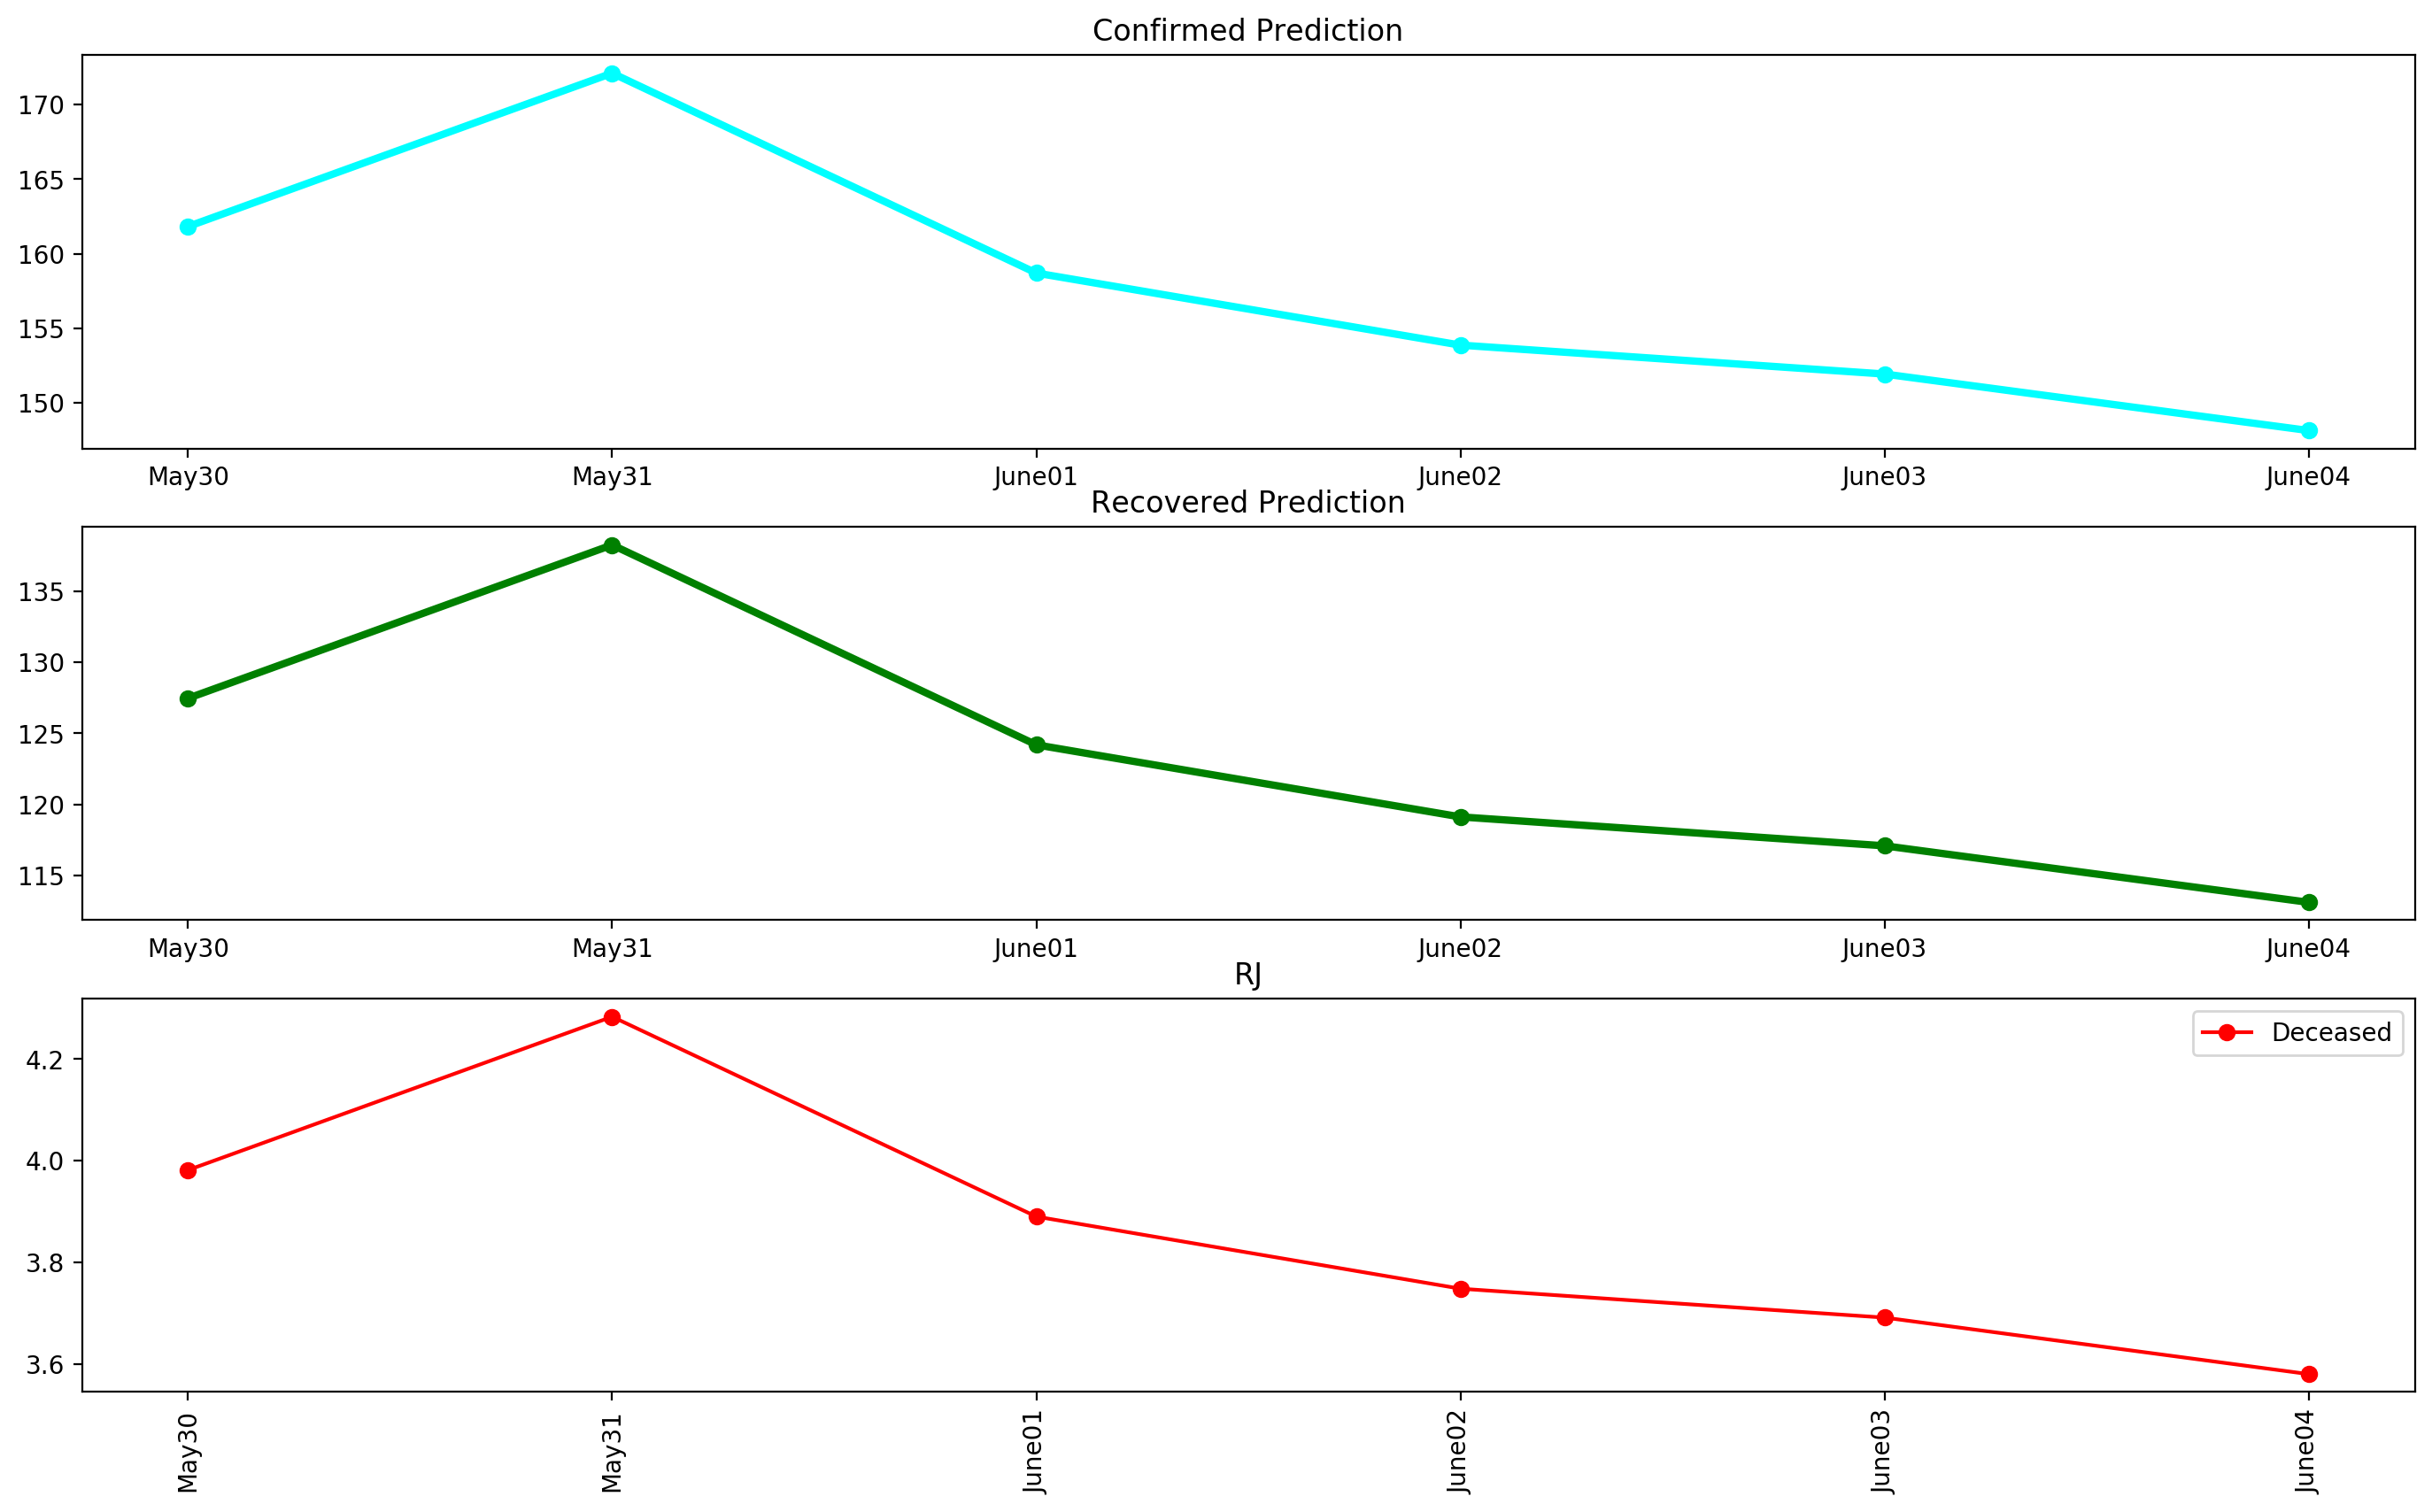

In [207]:
w = widgets.Dropdown(
    options=data.columns[2:],
    value=None,
    description='State:',
)
outs = widgets.Output()
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        state = change['new']
        with outs:
            clear_output()
            PlotAndPridict(state, 6)

w.observe(on_change)

display(w)